In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


Could not install packages due to an EnvironmentError: [Errno 2] No such file or directory: 'c:\\users\\nites\\onedrive\\documents\\12\\cricket\\cricket\\env\\lib\\site-packages\\jupyter_core-4.12.0.dist-info\\METADATA'

You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
#import required classes and packages
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Convolution2D
from keras.models import Sequential, load_model, Model
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import keras
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50 #resnet 50 class
import keras
from keras import layers
from keras.losses import CategoricalCrossentropy
from keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from keras.models import Model, load_model
from classification_models.resnet import ResNet18, preprocess_input#loading resnet18 class
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
c:\Users\Nites\OneDrive\Documents\12\Cricket\Cricket\env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Nites\OneDrive\Documents\12\Cricket\Cricket\env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Nites\OneDrive\Documents\12\Cricket\Cricket\env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [3]:
#define and load class labels found in dataset
path = "Dataset"
labels = []
X = []
Y = []
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())   
print("Cricket Trajectory Class Labels : "+str(labels))    

Cricket Trajectory Class Labels : ['ArmBall', 'Flipper', 'Googly', 'LegSpin', 'SwingIn', 'SwingOut']


In [4]:
#define function to get class label of given image
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [5]:
#load dataset image and process them
if os.path.exists("model/X.txt.npy"):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if images not process then read and process image pixels
    for root, dirs, directory in os.walk(path):#connect to dataset folder
        for j in range(len(directory)):#loop all images from dataset folder
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read images
                img = cv2.resize(img, (64, 64))#resize image
                X.append(img) #add image pixels to X array
                label = getLabel(name)#get image label id
                Y.append(label)#add image label                
    X = np.asarray(X)#convert array as numpy array
    Y = np.asarray(Y)
    np.save('model/X.txt',X)#save process images and labels
    np.save('model/Y.txt',Y)
print("Dataset images loaded")
print("Total images found in dataset : "+str(X.shape[0]))
print()

Dataset images loaded
Total images found in dataset : 272



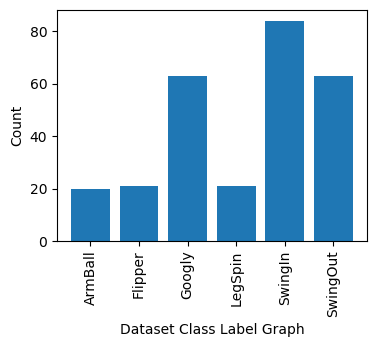

In [6]:
#visualizing class labels count found in dataset
names, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (4, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Sample Processed Image')

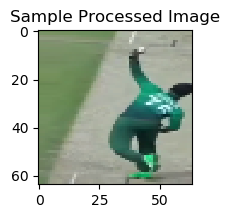

In [7]:
#display processed sample image
img = X[0]
plt.figure(figsize =(2, 2)) 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Processed Image")

In [8]:
#preprocess images like shuffling and normalization
X = X.astype('float32')
X = X/255 #normalized pixel values between 0 and 1
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle all images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Dataset Image Processing & Normalization Completed")
print("80% images used to train algorithms : "+str(X_train.shape[0]))
print("20% image used to train algorithms : "+str(X_test.shape[0]))

Dataset Image Processing & Normalization Completed
80% images used to train algorithms : 217
20% image used to train algorithms : 55


In [9]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [10]:
#function to calculate accuracy and other metrics
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))    
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(6, 3)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.xticks(rotation=90)
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()    

In [11]:
#train Resnet50 algorithm
resnet = ResNet50(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in resnet.layers:
    layer.trainable = False
headModel = resnet.output
headModel = AveragePooling2D(pool_size=(1, 1))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(y_train.shape[1], activation="softmax")(headModel)
resnet_model = Model(inputs=resnet.input, outputs=headModel)
resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])#compile and train the model
if os.path.exists("model/resnet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = resnet_model.fit(X_train, y_train, batch_size = 16, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/resnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    resnet_model.load_weights("model/resnet_weights.hdf5")
#predict on test data   
predict = resnet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("ResNet50", predict, y_test1)#call this function to calculate accuracy and other metrivcs

OSError: Unable to open file (truncated file: eof = 110223360, sblock->base_addr = 0, stored_eof = 120054616)


ResNet18 Accuracy  :  34.54545454545455
ResNet18 Precision : 5.757575757575758
ResNet18 Recall    : 16.666666666666664
ResNet18 FScore    : 8.558558558558559


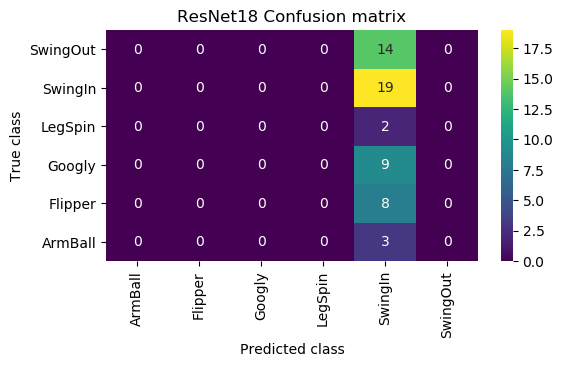

In [12]:
#training Resnet18 algorithm
resnet18 = ResNet18(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(resnet18.output)
output = Dense(y_train.shape[1], activation='softmax')(x)
resnet18_model = Model(inputs=[resnet18.input], outputs=[output])
resnet18_model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
if os.path.exists("model/resnet18_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnet18_weights.hdf5', verbose = 1, save_best_only = True)
    hist = resnet18_model.fit(X_train, y_train, batch_size = 16, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/resnet18_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    resnet18_model.load_weights("model/resnet18_weights.hdf5")
#predict on test data
predict = resnet18_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("ResNet18", predict, y_test1)#call this function to calculate accuracy and other metrivcs

AlexNet Accuracy  :  87.27272727272727
AlexNet Precision : 76.04166666666666
AlexNet Recall    : 77.38095238095238
AlexNet FScore    : 75.04347826086956


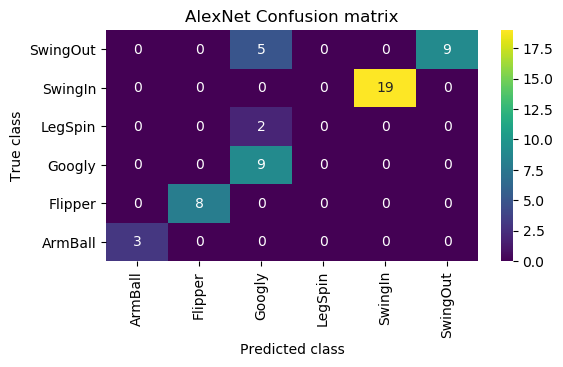

In [13]:
#training AlexNet model
alexnet_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(9,9), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(7,7), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(6,6), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(y_train.shape[1], activation='softmax')
])
alexnet_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])#compiling the model
#training and loading the model
if os.path.exists("model/alexnet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/alexnet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = alexnet_model.fit(X_train, y_train, batch_size = 16, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/alexnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    alexnet_model = load_model("model/alexnet_weights.hdf5")
#predict on test data
predict = alexnet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("AlexNet", predict, y_test1)#call this function to calculate accuracy and other metrivcs

Custom CNN Accuracy  :  98.18181818181819
Custom CNN Precision : 99.16666666666667
Custom CNN Recall    : 97.91666666666666
Custom CNN FScore    : 98.46153846153847


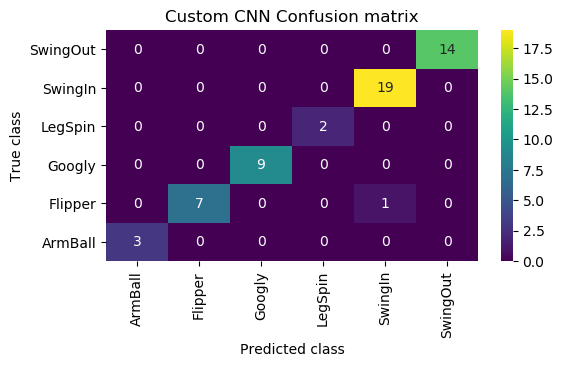

In [14]:
#train Custom CNN algorithm
custom_cnn = Sequential()
custom_cnn.add(Convolution2D(32, (3 , 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
custom_cnn.add(MaxPooling2D(pool_size = (2, 2)))
custom_cnn.add(Convolution2D(32, (3, 3), activation = 'relu'))
custom_cnn.add(MaxPooling2D(pool_size = (2, 2)))
custom_cnn.add(Flatten())
custom_cnn.add(Dense(units = 256, activation = 'relu'))
custom_cnn.add(Dense(units = y_train.shape[1], activation = 'softmax'))
custom_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])  
if os.path.exists("model/custom_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/custom_weights.hdf5', verbose = 1, save_best_only = True)
    hist = custom_cnn.fit(X_train, y_train, batch_size = 16, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/custom_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    custom_cnn.load_weights("model/custom_weights.hdf5")
#predict on test data    
predict = custom_cnn.predict(X_test)
y_test1 = np.argmax(y_test, axis=1)
predict = np.argmax(predict, axis=1)  
calculateMetrics("Custom CNN", predict, y_test1)#call this function to calculate accuracy and other metrivcs

In [15]:
#plot all algorithm performance in tabukar format
import pandas as pd
df = pd.DataFrame([['ResNet50','Accuracy',accuracy[0]],['ResNet50','Precision',precision[0]],['ResNet50','Recall',recall[0]],['ResNet50','FSCORE',fscore[0]],
                   ['ResNet18','Accuracy',accuracy[1]],['ResNet18','Precision',precision[1]],['ResNet18','Recall',recall[1]],['ResNet18','FSCORE',fscore[1]],
                   ['AlexNet','Accuracy',accuracy[2]],['AlexNet','Precision',precision[2]],['AlexNet','Recall',recall[2]],['AlexNet','FSCORE',fscore[2]],
                   ['Custom CNN','Accuracy',accuracy[3]],['Custom CNN','Precision',precision[3]],['Custom CNN','Recall',recall[3]],['Custom CNN','FSCORE',fscore[3]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(6, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

IndexError: list index out of range

In [16]:
#display all algorithm performnace
algorithms = ['Resnet50', 'ResNet18', 'AlexNet', 'Custom CNN']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data   

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,Resnet50,34.545455,5.757576,16.666667,8.558559
1,ResNet18,87.272727,76.041667,77.380952,75.043478
2,AlexNet,98.181818,99.166667,97.916667,98.461538


In [17]:
def values(filename, acc, loss):
    f = open(filename, 'rb')
    train_values = pickle.load(f)
    f.close()
    accuracy_value = train_values[acc]
    loss_value = train_values[loss]
    return accuracy_value, loss_value

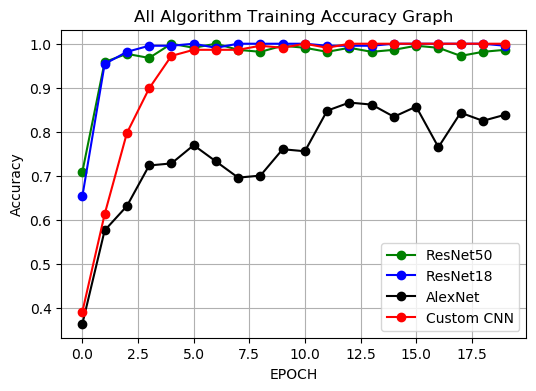

In [18]:
resnet50_acc, resnet50_loss = values("model/resnet_history.pckl", "accuracy", "loss")
resnet18_acc, resnet18_loss = values("model/resnet18_history.pckl", "accuracy", "loss")
alexnet_acc, alexnet_loss = values("model/alexnet_history.pckl", "accuracy", "loss")
custom_acc, custom_loss = values("model/custom_history.pckl", "accuracy", "loss")
    
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.plot(resnet50_acc, 'ro-', color = 'green')
plt.plot(resnet18_acc, 'ro-', color = 'blue')
plt.plot(alexnet_acc, 'ro-', color = 'black')
plt.plot(custom_acc, 'ro-', color = 'red')
plt.legend(['ResNet50', 'ResNet18','AlexNet','Custom CNN'], loc='lower right')
plt.title('All Algorithm Training Accuracy Graph')
plt.show()

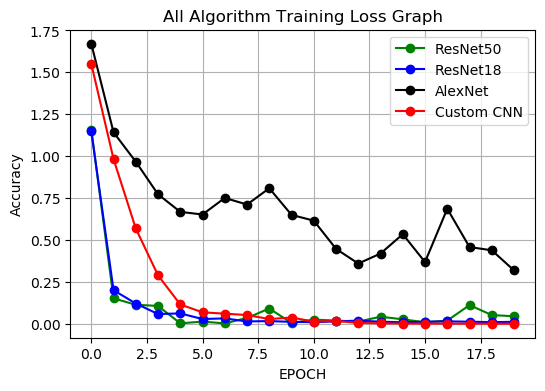

In [19]:
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.plot(resnet50_loss, 'ro-', color = 'green')
plt.plot(resnet18_loss, 'ro-', color = 'blue')
plt.plot(alexnet_loss, 'ro-', color = 'black')
plt.plot(custom_loss, 'ro-', color = 'red')
plt.legend(['ResNet50', 'ResNet18','AlexNet','Custom CNN'], loc='upper right')
plt.title('All Algorithm Training Loss Graph')
plt.show()

In [20]:
#use this function to predict fish species uisng extension model
def predict(image_path):
    image = cv2.imread(image_path)#read test image
    img = cv2.resize(image, (64,64))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,64,64,3)#convert image as 4 dimension
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image features as float
    img = img/255 #normalized image
    predict = custom_cnn.predict(img)#now predict dog breed
    predict = np.argmax(predict)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (600,400))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Estimated Motion Trajectory : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    plt.imshow(img)

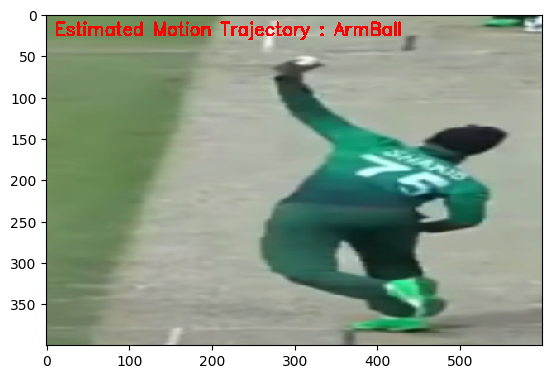

In [21]:
#call this function wwith test image to predict trajectory
predict("testImages/1.png")

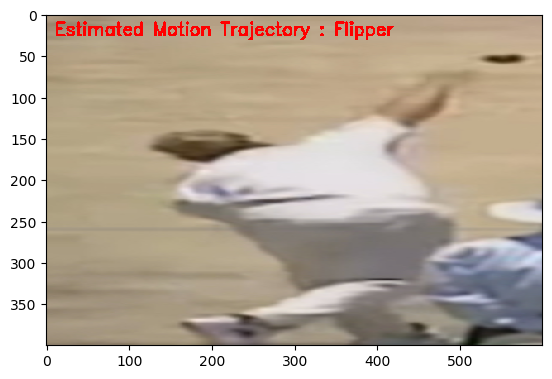

In [22]:
#call this function wwith test image to predict trajectory
predict("testImages/2.png")

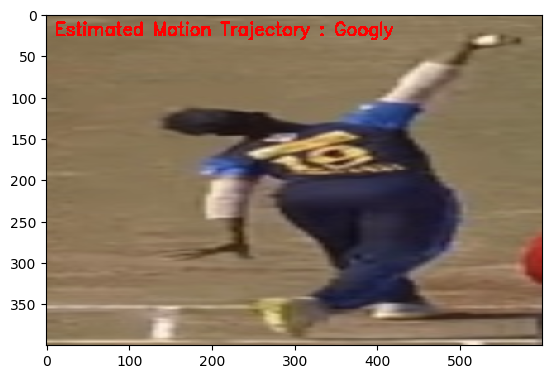

In [23]:
#call this function wwith test image to predict trajectory
predict("testImages/3.png")

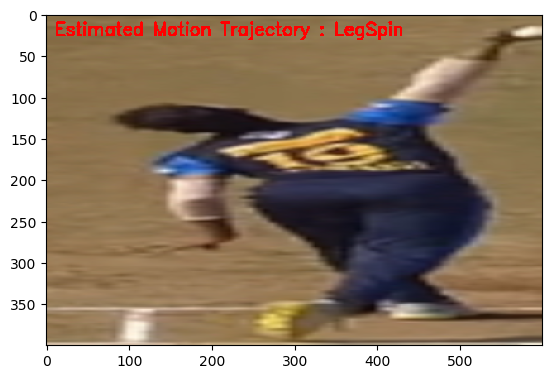

In [24]:
#call this function wwith test image to predict trajectory
predict("testImages/4.png")

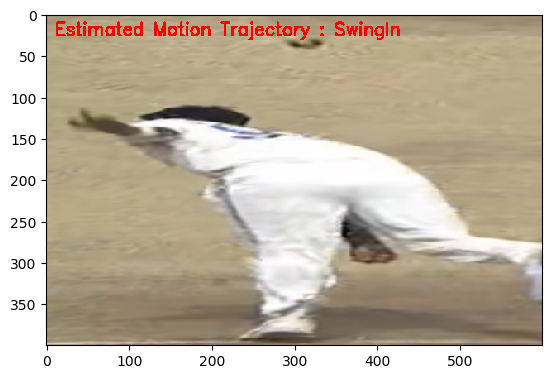

In [25]:
#call this function wwith test image to predict trajectory
predict("testImages/5.png")

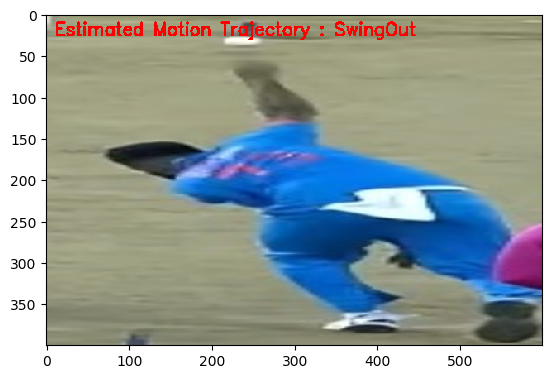

In [26]:
#call this function wwith test image to predict trajectory
predict("testImages/6.jpg")

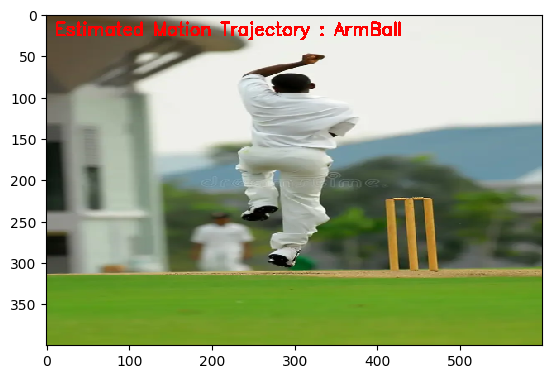

In [28]:
predict("testImages/ball.png")

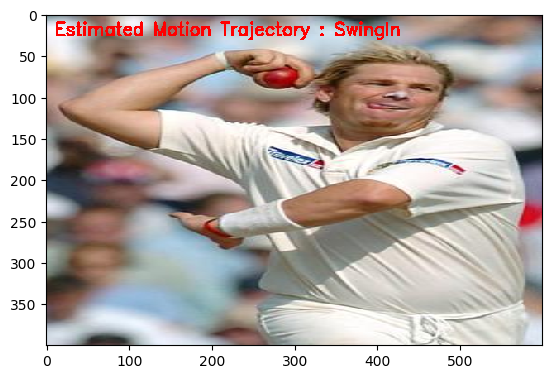

In [30]:
predict("testImages/image.png")

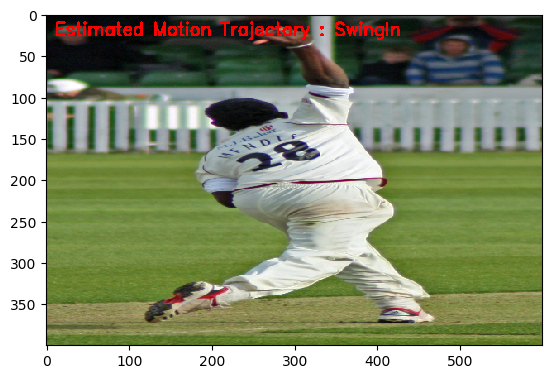

In [32]:
predict("testImages/swingin.png")